Using device: cuda
CLIP 模型加载成功！
Files already downloaded and verified
类别数量: 100


分类中: 100%|██████████| 1563/1563 [09:46<00:00,  2.67it/s]


Zero-shot 分类准确率: 60.85%


获取错误样本:   0%|          | 1/1563 [00:00<19:59,  1.30it/s]


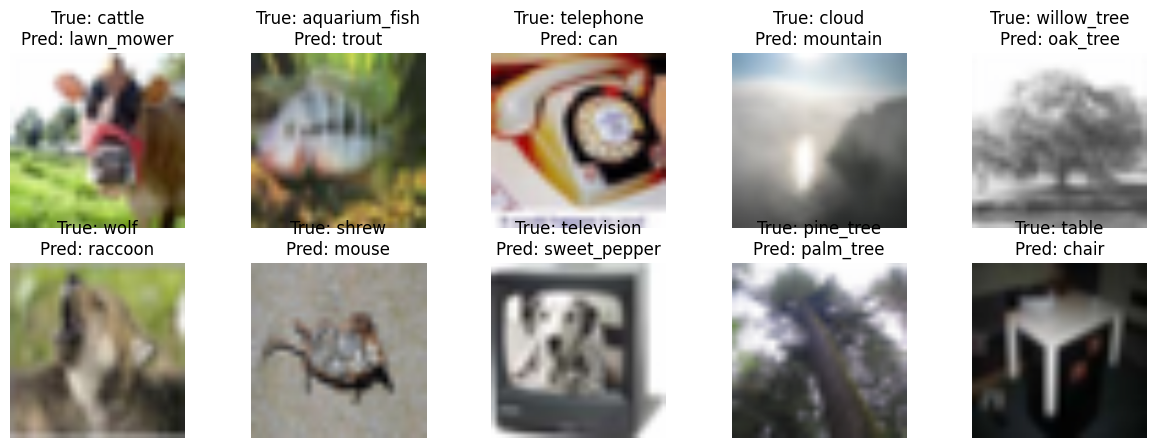

In [1]:
import clip
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# 选择设备
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 加载 CLIP 模型和预处理器
model, preprocess = clip.load("ViT-B/32", device=device)
print("CLIP 模型加载成功！")

# 定义数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), 
                         (0.26862954, 0.26130258, 0.27577711))
])

# 加载 CIFAR-100 数据集
dataset = datasets.CIFAR100(root="data", download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
class_names = dataset.classes
print(f"类别数量: {len(class_names)}")

# 构建文本描述
text_prompts = [f"a photo of a {classname}" for classname in class_names]
text_tokens = clip.tokenize(text_prompts).to(device)

# 编码文本
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Zero-shot 分类
correct = 0
total = 0

for images, labels in tqdm(dataloader, desc="分类中"):
    images = images.to(device)

    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = image_features @ text_features.T
        predictions = similarity.argmax(dim=1)
    
    correct += (predictions.cpu() == labels).sum().item()
    total += labels.size(0)

accuracy = correct / total * 100
print(f"Zero-shot 分类准确率: {accuracy:.2f}%")

# 获取错误分类样本
incorrect_samples = []
incorrect_predictions = []
true_labels = []
predicted_labels = []

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

for images, labels in tqdm(dataloader, desc="获取错误样本"):
    images = images.to(device)

    with torch.no_grad():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        similarity = image_features @ text_features.T
        predictions = similarity.argmax(dim=1)
    
    mask = predictions.cpu() != labels
    if mask.any():
        incorrect_samples.extend(images.cpu()[mask])
        incorrect_predictions.extend(predictions.cpu()[mask].numpy())
        true_labels.extend(labels.cpu()[mask].numpy())
        predicted_labels.extend(predictions.cpu()[mask].numpy())

    if len(incorrect_samples) >= 20:
        break

# 可视化错误分类样本
def show_images(images, true_labels, predicted_labels, class_names, num=10):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(2, 5, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * [0.26862954, 0.26130258, 0.27577711]) + [0.48145466, 0.4578275, 0.40821073]
        img = img.clip(0, 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        plt.axis('off')
    plt.show()

show_images(incorrect_samples, true_labels, predicted_labels, class_names, num=10)
